In [1]:
#importing necessary libraries
from api.mapbox_api_driving import MapboxAPI
import requests
from urllib.request import urlopen
import json
from shapely.geometry import shape, Polygon
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('default')
import geopandas as gpd
import geodatasets
import ast
from shapely import wkt
from pyproj import Geod
from collections import defaultdict
from shapely.ops import unary_union

In [2]:
#reading in library branch and population demographics, both with geometry data
branchInfo = gpd.read_file('../data/clean/branches.csv')
censusTracts = pd.read_csv('../data/clean/population_demographics.csv')

In [3]:
censusTracts.shape

(869, 63)

In [4]:
branchInfo.loc[branchInfo['BRANCH'] == 'Roosevelt']

,BRANCH,HOURS OF OPERATION,ADDRESS,CITY,STATE,ZIP,PHONE,WEBSITE,LOCATION,PERMANENTLY_CLOSED,geometry
60,Roosevelt,,1101 W. Taylor Street,Chicago,IL,60607,,,"(41.86943838326072, -87.6544586134924)",1,None


In [5]:
branchInfo = branchInfo.drop([60,60])
branchInfo = branchInfo.set_index('BRANCH')
branchInfo = branchInfo.reset_index()
branchInfo

,BRANCH,HOURS OF OPERATION,ADDRESS,CITY,STATE,ZIP,PHONE,WEBSITE,LOCATION,PERMANENTLY_CLOSED,geometry
0,Albany Park,"Mon. & Wed., 10-6; Tues. & Thurs., Noon-8; Fri...",3401 W. Foster Ave.,Chicago,IL,60625,(773) 539-5450,https://www.chipublib.org/locations/3/,"(41.97557881655979, -87.71361314512697)",0,None
1,Altgeld,"Mon. & Wed., Noon-8; Tues. & Thurs., 10-6; Fri...",955 E. 131st Street,Chicago,IL,60827,(312) 747-3270,https://www.chipublib.org/locations/4/,"(41.65719847558056, -87.59883829075173)",0,None
2,Archer Heights,"Mon. & Wed., Noon-8; Tues. & Thurs., 10-6; Fri...",5055 S. Archer Ave.,Chicago,IL,60632,(312) 747-9241,https://www.chipublib.org/locations/5/,"(41.80110836194246, -87.72648385568911)",0,None
3,Austin,"Mon. & Wed., Noon-8; Tues. & Thurs., 10-6; Fri...",5615 W. Race Ave.,Chicago,IL,60644,(312) 746-5038,https://www.chipublib.org/locations/6/,"(41.88917312206642, -87.7658203582574)",0,None
4,Austin-Irving,"Mon. & Wed., Noon-8; Tues. & Thurs., 10-6; Fri...",6100 W. Irving Park Rd.,Chicago,IL,60634,(312) 744-6222,https://www.chipublib.org/locations/7/,"(41.95312267684315, -87.77928489355646)",0,None
...,...,...,...,...,...,...,...,...,...,...,...
76,West Pullman,"Mon. & Wed., Noon-8; Tue. & Thu., 10-6; Fri. &...",830 W. 119th St.,Chicago,IL,60643,(312) 747-1425,https://www.chipublib.org/locations/78/,"(41.67790647382097, -87.6431683153105)",0,None
77,West Town,"Mon. & Wed., 10-6; Tues. & Thurs., Noon-8; Fri...",1625 W. Chicago Ave.,Chicago,IL,60622,(312) 743-0450,https://www.chipublib.org/locations/79/,"(41.89594730478282, -87.66829305460979)",0,None
78,"Whitney M. Young, Jr.","Mon. & Wed., 10-6; Tues. & Thurs., Noon-8; Fri...",415 East 79th St.,Chicago,IL,60619,(312) 747-0039,https://www.chipublib.org/locations/80/,"(41.7510184591363, -87.61495065361933)",0,None
79,Woodson Regional Library,"Mon. - Thurs., 9-8; Fri. & Sat., 9-5; Sun., 1-5",9525 S. Halsted St.,Chicago,IL,60628,(312) 747-6900,https://www.chipublib.org/locations/81/,"(41.720694885749005, -87.64304817213312)",0,None


In [6]:
branchCopy = branchInfo

In [7]:
branchCopy[['Latitude', 'Longitude']] = [ast.literal_eval(x)[:2] for x in branchCopy['LOCATION']]
branchCopy = branchCopy.drop(columns='LOCATION')


In [8]:
#removing unecessary columns from branchInfo
branchInfo = branchInfo.drop(columns = ['HOURS OF OPERATION', 'ADDRESS', 'CITY', 'STATE', 'ZIP', 'PHONE', 'WEBSITE','PERMANENTLY_CLOSED'])
#removing unecessary columns from censusTracts
censusTracts = censusTracts[['geoid','geometry','qualifying name']]

In [9]:
#converting censusTracts to a geodataframe (we could not load it as one since it already had a geometry column so we are simply
#converting the geometry column to a proper gpd geometry column).
censusTracts = gpd.GeoDataFrame(
    censusTracts.loc[:, [c for c in censusTracts.columns if c != "geometry"]],
    geometry=gpd.GeoSeries.from_wkt(censusTracts["geometry"]),
    crs="epsg:4326",
    )

In [10]:
branchInfo[['LATITUDE', 'LONGITUDE']] = [ast.literal_eval(x)[:2] for x in branchInfo['LOCATION']]
branchInfo.loc[:, 'LATITUDE'] = pd.to_numeric(branchInfo.loc[:, 'LATITUDE'])
branchInfo.loc[:, 'LONGITUDE'] = pd.to_numeric(branchInfo.loc[:, 'LONGITUDE'])


In [11]:
#helper method to ensure that two polygons overlap before getting the intersection. Gets the intersection then calculates
#the percent of overlapping area for a census tract and saves it to a dictionary with the census tract geo-id as the key and
#the percent as the value.
def check(polygon1, df, geoname, dictionary, key, iso_dict, branchname):
    for i in range(len(df)):
        if polygon1.intersects(df.loc[i,geoname]): 
            
            overlapPolygon = (polygon1.intersection(df.loc[i,geoname]))
            iso_dict[df.loc[i, key]] = overlapPolygon
            poly_area, poly_perimeter = geod.geometry_area_perimeter(overlapPolygon)
            overlapArea = poly_area*-1
            propOverlap = overlapArea / df.loc[i,'Area']
            dictionary[df.loc[i, key]] = propOverlap
            
            
            if len(df.loc[i, 'polygons in census']) > 0:
                hold = (df.loc[i, 'polygons in census'][0]).copy()
                c = len(hold.items())
                hold[c] = overlapPolygon
                df.loc[i, 'polygons in census']= [hold]
                
                hold = (df.loc[i, 'area coverage of each polygon in census'][0]).copy()
                c = len(hold.items())
                hold[branchname] = propOverlap
                df.loc[i, 'area coverage of each polygon in census']= [hold]
 
 
            else:
                first = {0:overlapPolygon}
                df.loc[i, 'polygons in census'] = [first]
                
                first = {branchname:propOverlap}
                df.loc[i, 'area coverage of each polygon in census'] = [first]
            
    return dictionary


In [12]:
#sets the crs of gpd types
def geoSetup(gdf):
    
    gdf = gdf.set_crs('EPSG:4326')
    

In [13]:
#cdf = gdf of geometry area which you want to get the coverage score
#idf = gdf of points for which you want to get an isochrone and dictionary of percent of overlap in cdf areas
#scoreString = a string that is the name of the coverage score column you choose
#dictString = a string that is the name of the dictionary column you choose
#cgs = a string that is the name of the geometry column in the cdf
#igs = a string that is the name of the geometry column in the idf
#lat = a string that is the name of the latitude column in the idf
#lon = a string that is the name of the longitude column in the idf
#key = a string that is the name of the column in the cdf that you want to represent the key of the dictionary
#travelTime = an integer of the amount of time traveled you wish to calculate the isochrone

def appendADS(cdf, idf, scoreString, dictString, cgs, igs, lat, lon, key, travelTime):
    api = MapboxAPI()
    cdf[scoreString] = 0.0
    cdf['polygons in census'] = np.empty((len(cdf), 0)).tolist()
    cdf['area coverage of each polygon in census'] = np.empty((len(cdf), 0)).tolist()
    idf['number of census tracts reached'] = 0
    idf[dictString] = ''
    censusAreas = []
    global geod 
    geod = Geod(ellps='WGS84')
   
    geoSetup(cdf)
    geoSetup(idf)
   
    for index, row in cdf.iterrows():
        poly_area, poly_perimeter = geod.geometry_area_perimeter(row[cgs])
        poly_area = poly_area*-1
        censusAreas.append(poly_area)
    
    cdf['Area'] = censusAreas

    
   
    for i in range(len(idf)):
        # Create a new dictionary for tracking isochrones
        iso_dict = defaultdict(list)
        dictionary = {}
        api_response =  api.get_data((idf.loc[i,lat],idf.loc[i,lon]), travelTime)
        idf.loc[i,igs] = shape(api_response)
        dictionary = check(idf.loc[i,igs], cdf, cgs, dictionary, key, iso_dict, idf.loc[i,'BRANCH'])
        idf.loc[i,dictString] = [dictionary]
        idf.loc[i,'iso geometries'] = [iso_dict]
        idf.loc[i, 'number of census tracts reached'] = len(dictionary.items())
        
        for j in range(len(cdf)):
             if dictionary.get(cdf.loc[j, key]) != None:
                score = cdf.loc[j, scoreString]
                cdf.loc[j, scoreString] = score + dictionary.get(cdf.loc[j, key])
            
    for i in range(len(cdf)):
        if len(cdf.loc[i, 'polygons in census']) > 0:
            gl = []
            cdf.loc[i, 'number of polygons in census tract'] = len(cdf.loc[i, 'polygons in census'][0])
            toMerge = (cdf.loc[i, 'polygons in census'][0]).copy()
            for tract_key, polygons in toMerge.items():
                gl.append(polygons)
            merged_geom = unary_union(gl)
            merged_area, _ = geod.geometry_area_perimeter(merged_geom)
            merged_area *= -1
            area_val = merged_area / cdf.loc[i,'Area']
            cdf.loc[i, 'percent covered by at least one library'] = area_val
        
        if len(cdf.loc[i, 'area coverage of each polygon in census']) > 0:
            toAddPerc = 0
            toAdd = (cdf.loc[i, 'area coverage of each polygon in census'][0]).copy()
            for tract_key, percent in toAdd.items():
                toAddPerc = toAddPerc + percent
            cdf.loc[i, 'added percentages'] = toAddPerc
            
        else:
            cdf.loc[i, 'added percentages'] = 0
            cdf.loc[i, 'percent covered by at least one library'] = 0
            cdf.loc[i, 'number of polygons in census tract'] = 0
                
 

In [14]:
appendADS(censusTracts,branchInfo, 'raw score', 'list of dict','geometry','geometry','LATITUDE','LONGITUDE','geoid', 20)

In [15]:
branchInfo

,BRANCH,LOCATION,geometry,Latitude,Longitude,LATITUDE,LONGITUDE,number of census tracts reached,list of dict,iso geometries
0,Albany Park,"(41.97557881655979, -87.71361314512697)","POLYGON ((-87.80961 42.16437, -87.81096 42.163...",41.975579,-87.713613,41.975579,-87.713613,233,"[{17031222800: 0.2637840144371779, 17031222900...","{17031222800: POLYGON ((-87.715613 41.916874, ..."
1,Altgeld,"(41.65719847558056, -87.59883829075173)","POLYGON ((-87.61484 41.85600, -87.61509 41.853...",41.657198,-87.598838,41.657198,-87.598838,231,"[{17031823304: 0.9790866056237835, 17031740400...",[{17031823304: MULTIPOLYGON (((-87.69354320345...
2,Archer Heights,"(41.80110836194246, -87.72648385568911)","POLYGON ((-87.64648 41.88731, -87.64949 41.881...",41.801108,-87.726484,41.801108,-87.726484,282,"[{17031740300: 0.02422449897543889, 1703182280...","[{17031740300: POLYGON ((-87.720484 41.69523, ..."
3,Austin,"(41.88917312206642, -87.7658203582574)","POLYGON ((-87.76782 41.95812, -87.77036 41.955...",41.889173,-87.765820,41.889173,-87.765820,262,"[{17031560200: 0.06745062802903973, 1703156010...","[{17031560200: POLYGON ((-87.74382 41.814451, ..."
4,Austin-Irving,"(41.95312267684315, -87.77928489355646)","POLYGON ((-87.75929 42.08080, -87.75965 42.071...",41.953123,-87.779285,41.953123,-87.779285,204,"[{17031812600: 0.9615727964660463, 17031252000...",[{17031812600: MULTIPOLYGON (((-87.77468357379...
...,...,...,...,...,...,...,...,...,...,...
76,West Pullman,"(41.67790647382097, -87.6431683153105)","POLYGON ((-87.61917 41.86612, -87.61940 41.861...",41.677906,-87.643168,41.677906,-87.643168,260,"[{17031823303: 1.0, 17031823304: 1.0, 17031740...","[{17031823303: POLYGON ((-87.720304 41.683963,..."
77,West Town,"(41.89594730478282, -87.66829305460979)","POLYGON ((-87.76829 42.03014, -87.76844 42.021...",41.895947,-87.668293,41.895947,-87.668293,465,"[{17031440600: 0.0034788977621597987, 17031842...",[{17031440600: POLYGON ((-87.62412585763063 41...
78,"Whitney M. Young, Jr.","(41.7510184591363, -87.61495065361933)","POLYGON ((-87.65895 41.89818, -87.65905 41.894...",41.751018,-87.614951,41.751018,-87.614951,378,"[{17031823303: 0.6022989553636416, 17031823304...",[{17031823303: POLYGON ((-87.72047603809278 41...
79,Woodson Regional Library,"(41.720694885749005, -87.64304817213312)","POLYGON ((-87.64505 41.88625, -87.64880 41.882...",41.720695,-87.643048,41.720695,-87.643048,335,"[{17031823303: 1.0, 17031823304: 1.0, 17031740...","[{17031823303: POLYGON ((-87.720304 41.683963,..."


In [16]:
file_path = '../data/clean/branchDataWithReachCount.csv'

branchInfo.to_csv(file_path, index=False)

In [17]:
branchInfo.sort_values(by = 'number of census tracts reached', ascending=False)

,BRANCH,LOCATION,geometry,Latitude,Longitude,LATITUDE,LONGITUDE,number of census tracts reached,list of dict,iso geometries
31,Harold Washington Library Center,"(41.87686252958797, -87.62779697013237)","POLYGON ((-87.65580 41.99780, -87.66420 41.990...",41.876863,-87.627797,41.876863,-87.627797,506,"[{17031490800: 0.17109983541537413, 1703149050...","[{17031490800: POLYGON ((-87.605928 41.712863,..."
17,Chinatown,"(41.85412074173438, -87.63195792246246)","POLYGON ((-87.64796 41.96621, -87.64799 41.964...",41.854121,-87.631958,41.854121,-87.631958,502,"[{17031540101: 0.0006057444492104001, 17031550...","[{17031540101: POLYGON ((-87.583958 41.652311,..."
77,West Town,"(41.89594730478282, -87.66829305460979)","POLYGON ((-87.76829 42.03014, -87.76844 42.021...",41.895947,-87.668293,41.895947,-87.668293,465,"[{17031440600: 0.0034788977621597987, 17031842...",[{17031440600: POLYGON ((-87.62412585763063 41...
75,West Loop,"(41.8837105009142, -87.6545650515331)","POLYGON ((-87.75056 41.99810, -87.75257 41.992...",41.883711,-87.654565,41.883711,-87.654565,458,"[{17031490600: 0.13255005359069483, 1703183400...","[{17031490600: POLYGON ((-87.624565 41.716147,..."
15,Chicago Bee,"(41.82824306445502, -87.6263495444489)","POLYGON ((-87.64435 41.95630, -87.64460 41.948...",41.828243,-87.626350,41.828243,-87.626350,458,"[{17031821200: 0.9487850657677122, 17031750500...",[{17031821200: MULTIPOLYGON (((-87.66815729574...
...,...,...,...,...,...,...,...,...,...,...
59,Rogers Park,"(42.00682227244734, -87.67330813329413)","POLYGON ((-87.70931 42.07809, -87.71068 42.074...",42.006822,-87.673308,42.006822,-87.673308,148,"[{17031081401: 0.0800060805420358, 17031081300...","[{17031081401: POLYGON ((-87.617308 41.895313,..."
58,Roden,"(41.99199760467718, -87.79820642998901)","POLYGON ((-87.88021 42.14669, -87.88274 42.146...",41.991998,-87.798206,41.991998,-87.798206,147,"[{17031250500: 0.006401539737499151, 170318111...",[{17031250500: MULTIPOLYGON (((-87.806206 41.9...
23,Dunning,"(41.94319949471892, -87.81395164414246)","POLYGON ((-87.86795 42.09363, -87.86807 42.087...",41.943199,-87.813952,41.943199,-87.813952,133,"[{17031812600: 0.7850704385376781, 17031252000...",[{17031812600: POLYGON ((-87.77475212460527 41...
55,Oriole Park,"(41.978098111742476, -87.81420029973704)","POLYGON ((-87.87420 42.16133, -87.87453 42.156...",41.978098,-87.814200,41.978098,-87.814200,108,"[{17031810900: 0.8068706925966047, 17031250500...",[{17031810900: MULTIPOLYGON (((-87.80582828660...


In [18]:
censusTracts

,geoid,qualifying name,geometry,raw score,polygons in census,area coverage of each polygon in census,Area,number of polygons in census tract,percent covered by at least one library,added percentages
0,17031823303,"Census Tract 8233.03, Cook County, Illinois","POLYGON ((-87.72096 41.68395, -87.72030 41.683...",12.662845,"[{0: POLYGON ((-87.720304 41.683963, -87.72006...","[{'Beverly': 1.0, 'Brainerd': 1.0, 'Chicago La...",1.081697e+00,14.0,0.999213,12.662845
1,17031823304,"Census Tract 8233.04, Cook County, Illinois","MULTIPOLYGON (((-87.72004 41.68397, -87.72006 ...",14.987181,[{0: MULTIPOLYGON (((-87.69354320345145 41.698...,"[{'Altgeld': 0.9790866056237835, 'Avalon': 0.9...",3.526503e+05,19.0,1.000001,14.987181
2,17031740400,"Census Tract 7404, Cook County, Illinois","POLYGON ((-87.72008 41.69127, -87.71937 41.691...",12.136007,"[{0: POLYGON ((-87.710541 41.682901, -87.70883...","[{'Altgeld': 0.1821176284314634, 'Avalon': 0.1...",2.782659e+06,18.0,1.000000,12.136007
3,17031740300,"Census Tract 7403, Cook County, Illinois","POLYGON ((-87.72043 41.69857, -87.72007 41.698...",14.588780,"[{0: POLYGON ((-87.702712 41.693072, -87.70095...","[{'Altgeld': 0.04793598438819895, 'Archer Heig...",1.319688e+06,19.0,1.000000,14.588780
4,17031822802,"Census Tract 8228.02, Cook County, Illinois","MULTIPOLYGON (((-87.72075 41.70204, -87.72075 ...",14.858653,[{0: MULTIPOLYGON (((-87.72074518791808 41.701...,"[{'Archer Heights': 0.8586533409324535, 'Bever...",1.577396e+01,15.0,1.000000,14.858653
...,...,...,...,...,...,...,...,...,...,...
864,17031320400,"Census Tract 3204, Cook County, Illinois","POLYGON ((-87.62764 41.88206, -87.62759 41.882...",38.852473,[{0: POLYGON ((-87.61632202143322 41.880553331...,"[{'Archer Heights': 0.6630505657458964, 'Austi...",8.033379e+05,47.0,1.000000,38.852473
865,17031320101,"Census Tract 3201.01, Cook County, Illinois","POLYGON ((-87.62086 41.88188, -87.62082 41.882...",32.093637,[{0: POLYGON ((-87.61636324731285 41.880912112...,"[{'Archer Heights': 0.02204744053147158, 'Aust...",4.902799e+05,39.0,1.000000,32.093637
866,17031081403,"Census Tract 814.03, Cook County, Illinois","MULTIPOLYGON (((-87.62431 41.88911, -87.62431 ...",25.253648,"[{0: POLYGON ((-87.61357 41.888909, -87.613431...","[{'Back of the Yards': 0.0018430597689669823, ...",5.956278e+05,37.0,0.986860,25.253648
867,17031081402,"Census Tract 814.02, Cook County, Illinois","POLYGON ((-87.61754 41.89345, -87.61716 41.893...",18.242432,"[{0: POLYGON ((-87.599472 41.891551, -87.59959...","[{'Bezazian': 0.6197511531108876, 'Blackstone'...",5.776787e+05,32.0,0.822223,18.242432


In [19]:
censusTracts.sort_values(by = 'number of polygons in census tract', ascending = False)

,geoid,qualifying name,geometry,raw score,polygons in census,area coverage of each polygon in census,Area,number of polygons in census tract,percent covered by at least one library,added percentages
322,17031340600,"Census Tract 3406, Cook County, Illinois","POLYGON ((-87.63625 41.83088, -87.63623 41.830...",50.427823,"[{0: POLYGON ((-87.636226 41.830881, -87.63615...","[{'Altgeld': 1.0, 'Archer Heights': 1.0, 'Aust...",4.965761e+05,57.0,1.000000,50.427823
358,17031841100,"Census Tract 8411, Cook County, Illinois","POLYGON ((-87.64325 41.84959, -87.64271 41.849...",48.191542,"[{0: POLYGON ((-87.629627 41.851987, -87.62928...","[{'Altgeld': 0.3688540757978285, 'Archer Heigh...",1.146240e+06,57.0,1.000000,48.191542
346,17031843200,"Census Tract 8432, Cook County, Illinois","POLYGON ((-87.67780 41.85214, -87.67633 41.852...",38.195067,"[{0: POLYGON ((-87.643838 41.850198, -87.64310...","[{'Altgeld': 0.012932370793977924, 'Archer Hei...",3.093995e+06,57.0,1.000000,38.195067
861,17031841000,"Census Tract 8410, Cook County, Illinois","POLYGON ((-87.62921 41.84778, -87.62922 41.847...",49.200736,"[{0: MULTIPOLYGON (((-87.628838 41.848352, -87...","[{'Altgeld': 0.49448690809915824, 'Archer Heig...",1.055081e+06,57.0,1.000000,49.200736
319,17031835500,"Census Tract 8355, Cook County, Illinois","POLYGON ((-87.63617 41.82359, -87.63612 41.823...",48.494493,"[{0: POLYGON ((-87.636118 41.823586, -87.63608...","[{'Altgeld': 1.0, 'Archer Heights': 1.0, 'Aust...",9.140149e+05,56.0,1.000000,48.494493
...,...,...,...,...,...,...,...,...,...,...
798,17031811701,"Census Tract 8117.01, Cook County, Illinois","MULTIPOLYGON (((-87.92020 41.95334, -87.92020 ...",4.980700,[{0: MULTIPOLYGON (((-87.914451 41.95647333586...,"[{'Austin-Irving': 0.6809622626496928, 'Dunnin...",2.860783e+05,8.0,1.000001,4.980700
797,17043840000,"Census Tract 8400, DuPage County, Illinois","POLYGON ((-87.93897 41.99352, -87.93893 41.993...",2.414584,"[{0: POLYGON ((-87.929285 41.958153, -87.93060...","[{'Austin-Irving': 0.13173403740515685, 'Dunni...",6.849187e+06,7.0,1.000000,2.414584
795,17043840801,"Census Tract 8408.01, DuPage County, Illinois","MULTIPOLYGON (((-87.93906 41.95849, -87.93900 ...",3.990812,[{0: MULTIPOLYGON (((-87.93680542263694 41.956...,"[{'Austin-Irving': 0.9893751792424096, 'Dunnin...",2.092095e+04,6.0,1.000000,3.990812
817,17031770500,"Census Tract 7705, Cook County, Illinois","MULTIPOLYGON (((-87.92056 42.00483, -87.92061 ...",2.568369,"[{0: POLYGON ((-87.924391 42.00676, -87.925819...","[{'Dunning': 0.026891709463067143, 'Edgebrook'...",1.799139e+05,5.0,1.000000,2.568369


In [20]:
censusTracts.sort_values(by = 'percent covered by at least one library', ascending = False)

,geoid,qualifying name,geometry,raw score,polygons in census,area coverage of each polygon in census,Area,number of polygons in census tract,percent covered by at least one library,added percentages
18,17031826401,"Census Tract 8264.01, Cook County, Illinois","MULTIPOLYGON (((-87.61231 41.64460, -87.61226 ...",15.106779,"[{0: MULTIPOLYGON (((-87.612257 41.644602, -87...","[{'Altgeld': 1.0, 'Avalon': 1.0, 'Beverly': 1....",2.270740e+03,18.0,1.000711,15.106779
790,17031810301,"Census Tract 8103.01, Cook County, Illinois","MULTIPOLYGON (((-87.69017 42.01953, -87.69077 ...",10.843426,[{0: MULTIPOLYGON (((-87.69077013044182 42.019...,"[{'Albany Park': 1.0, 'Bezazian': 0.7434840162...",8.852821e+01,12.0,1.000153,10.843426
792,17031807900,"Census Tract 8079, Cook County, Illinois","MULTIPOLYGON (((-87.76203 42.00237, -87.76204 ...",17.899242,[{0: MULTIPOLYGON (((-87.76204238149201 42.002...,"[{'Albany Park': 1.0, 'Austin-Irving': 1.0, 'B...",4.173064e+01,22.0,1.000047,17.899242
441,17031813301,"Census Tract 8133.01, Cook County, Illinois","MULTIPOLYGON (((-87.75843 41.86569, -87.75786 ...",20.224147,[{0: MULTIPOLYGON (((-87.75811532445316 41.865...,"[{'Archer Heights': 0.8392953540029803, 'Austi...",1.221551e+01,22.0,1.000021,20.224147
720,17031810501,"Census Tract 8105.01, Cook County, Illinois","MULTIPOLYGON (((-87.83670 41.96517, -87.83670 ...",9.805583,"[{0: MULTIPOLYGON (((-87.836701 41.965455, -87...","[{'Austin-Irving': 1.0, 'Dunning': 1.0, 'Edgeb...",4.080348e+02,12.0,1.000013,9.805583
...,...,...,...,...,...,...,...,...,...,...
862,17031330101,"Census Tract 3301.01, Cook County, Illinois","POLYGON ((-87.62267 41.86756, -87.62256 41.867...",39.274701,"[{0: POLYGON ((-87.618838 41.850585, -87.61445...","[{'Altgeld': 0.057176732134408305, 'Archer Hei...",1.872176e+06,55.0,0.968646,39.274701
283,17031410900,"Census Tract 4109, Cook County, Illinois","POLYGON ((-87.58739 41.79619, -87.58735 41.796...",29.410498,[{0: POLYGON ((-87.58725163092498 41.798700889...,"[{'Archer Heights': 0.7273675184197688, 'Avalo...",3.931568e+05,37.0,0.949874,29.410498
867,17031081402,"Census Tract 814.02, Cook County, Illinois","POLYGON ((-87.61754 41.89345, -87.61716 41.893...",18.242432,"[{0: POLYGON ((-87.599472 41.891551, -87.59959...","[{'Bezazian': 0.6197511531108876, 'Blackstone'...",5.776787e+05,32.0,0.822223,18.242432
112,17031460100,"Census Tract 4601, Cook County, Illinois","POLYGON ((-87.55407 41.75189, -87.55384 41.751...",9.605354,"[{0: POLYGON ((-87.530838 41.735686, -87.53970...","[{'Altgeld': 0.5720926691482477, 'Avalon': 0.7...",3.028235e+06,22.0,0.791379,9.605354


In [21]:
censusTracts['raw score norm'] = censusTracts['raw score']
censusTracts.loc[censusTracts['raw score norm'] > 1, 'raw score norm'] = 1.0
censusTracts['weighted score'] = censusTracts['number of polygons in census tract'] * censusTracts['percent covered by at least one library']
censusTracts.sort_values(by = 'weighted score', ascending = False)

,geoid,qualifying name,geometry,raw score,polygons in census,area coverage of each polygon in census,Area,number of polygons in census tract,percent covered by at least one library,added percentages,raw score norm,weighted score
346,17031843200,"Census Tract 8432, Cook County, Illinois","POLYGON ((-87.67780 41.85214, -87.67633 41.852...",38.195067,"[{0: POLYGON ((-87.643838 41.850198, -87.64310...","[{'Altgeld': 0.012932370793977924, 'Archer Hei...",3.093995e+06,57.0,1.000000,38.195067,1.0,57.000001
322,17031340600,"Census Tract 3406, Cook County, Illinois","POLYGON ((-87.63625 41.83088, -87.63623 41.830...",50.427823,"[{0: POLYGON ((-87.636226 41.830881, -87.63615...","[{'Altgeld': 1.0, 'Archer Heights': 1.0, 'Aust...",4.965761e+05,57.0,1.000000,50.427823,1.0,57.000000
861,17031841000,"Census Tract 8410, Cook County, Illinois","POLYGON ((-87.62921 41.84778, -87.62922 41.847...",49.200736,"[{0: MULTIPOLYGON (((-87.628838 41.848352, -87...","[{'Altgeld': 0.49448690809915824, 'Archer Heig...",1.055081e+06,57.0,1.000000,49.200736,1.0,57.000000
358,17031841100,"Census Tract 8411, Cook County, Illinois","POLYGON ((-87.64325 41.84959, -87.64271 41.849...",48.191542,"[{0: POLYGON ((-87.629627 41.851987, -87.62928...","[{'Altgeld': 0.3688540757978285, 'Archer Heigh...",1.146240e+06,57.0,1.000000,48.191542,1.0,56.999999
357,17031840200,"Census Tract 8402, Cook County, Illinois","POLYGON ((-87.65707 41.84819, -87.65677 41.848...",43.445389,"[{0: POLYGON ((-87.654848 41.845208, -87.64575...","[{'Altgeld': 0.20197670763876685, 'Archer Heig...",8.628704e+05,56.0,1.000000,43.445389,1.0,56.000002
...,...,...,...,...,...,...,...,...,...,...,...,...
798,17031811701,"Census Tract 8117.01, Cook County, Illinois","MULTIPOLYGON (((-87.92020 41.95334, -87.92020 ...",4.980700,[{0: MULTIPOLYGON (((-87.914451 41.95647333586...,"[{'Austin-Irving': 0.6809622626496928, 'Dunnin...",2.860783e+05,8.0,1.000001,4.980700,1.0,8.000006
797,17043840000,"Census Tract 8400, DuPage County, Illinois","POLYGON ((-87.93897 41.99352, -87.93893 41.993...",2.414584,"[{0: POLYGON ((-87.929285 41.958153, -87.93060...","[{'Austin-Irving': 0.13173403740515685, 'Dunni...",6.849187e+06,7.0,1.000000,2.414584,1.0,7.000000
795,17043840801,"Census Tract 8408.01, DuPage County, Illinois","MULTIPOLYGON (((-87.93906 41.95849, -87.93900 ...",3.990812,[{0: MULTIPOLYGON (((-87.93680542263694 41.956...,"[{'Austin-Irving': 0.9893751792424096, 'Dunnin...",2.092095e+04,6.0,1.000000,3.990812,1.0,6.000001
817,17031770500,"Census Tract 7705, Cook County, Illinois","MULTIPOLYGON (((-87.92056 42.00483, -87.92061 ...",2.568369,"[{0: POLYGON ((-87.924391 42.00676, -87.925819...","[{'Dunning': 0.026891709463067143, 'Edgebrook'...",1.799139e+05,5.0,1.000000,2.568369,1.0,5.000000


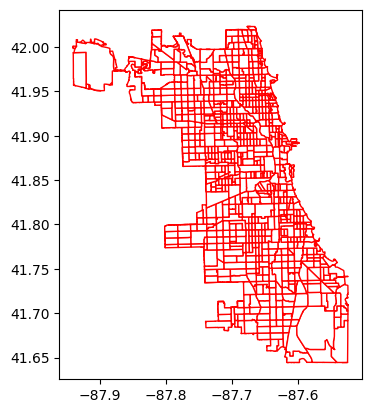

In [22]:
branchCopy = gpd.GeoDataFrame(
     branchCopy, geometry=gpd.points_from_xy(branchCopy.Longitude, branchCopy.Latitude), crs="EPSG:3435")

base = censusTracts.plot(color='white', edgecolor='red')


<Axes: title={'center': 'Raw Score'}>

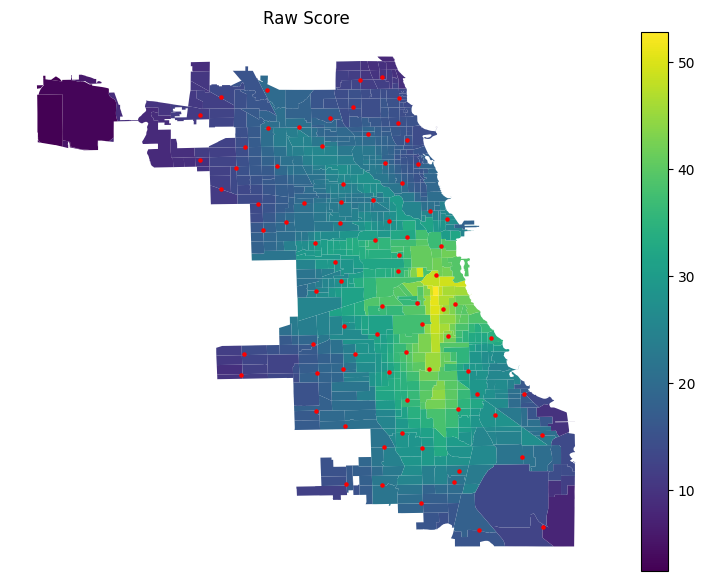

In [23]:
ax = censusTracts.plot(column = 'raw score', legend = True, 
                figsize=(10,7),missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "label": "Missing values",
    })


ax.set_axis_off()
ax.set_title("Raw Score")
branchCopy.plot(ax=ax, marker='o', color='red', markersize=5, edgecolor='red')


<Axes: title={'center': 'Raw Score Normalized'}>

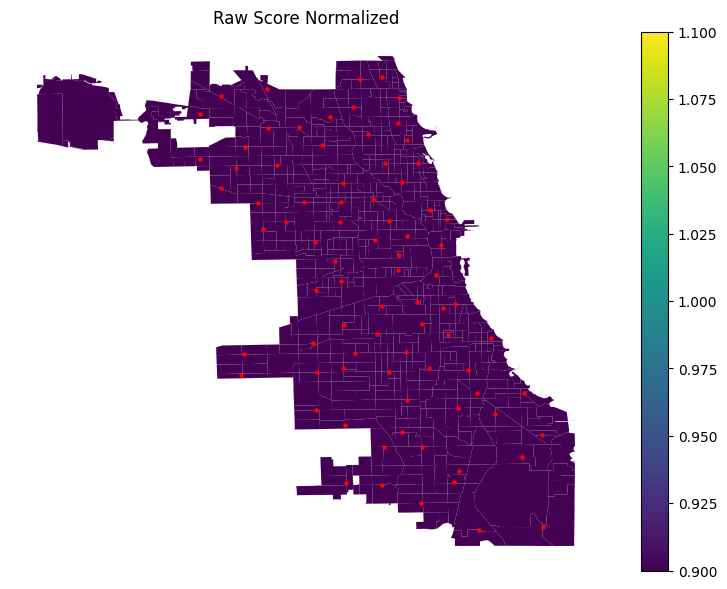

In [24]:
ax = censusTracts.plot(column = 'raw score norm', legend = True, 
                figsize=(10,7),missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "label": "Missing values",
    })


ax.set_axis_off()
ax.set_title("Raw Score Normalized")
branchCopy.plot(ax=ax, marker='o', color='red', markersize=5, edgecolor='red')


<Axes: title={'center': 'Percent of access to at least one library'}>

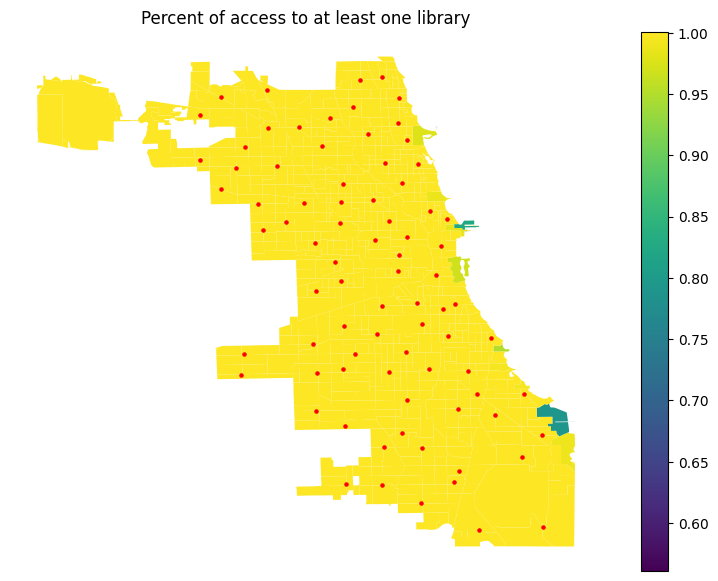

In [25]:
ax = censusTracts.plot(column = 'percent covered by at least one library', legend = True, 
                figsize=(10,7),missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "label": "Missing values",
    })


ax.set_axis_off()
ax.set_title("Percent of access to at least one library")
branchCopy.plot(ax=ax, marker='o', color='red', markersize=5)


<Axes: title={'center': 'Weighted Score'}>

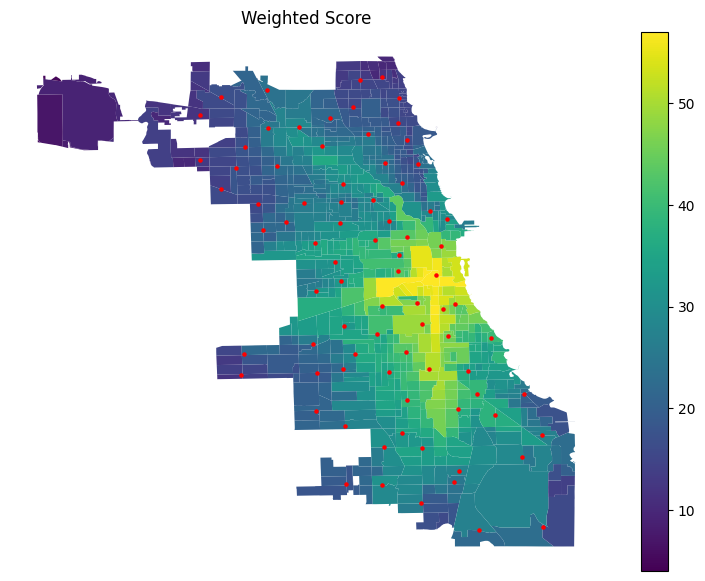

In [26]:
ax = censusTracts.plot(column = 'weighted score', legend = True, 
                figsize=(10,7),missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "label": "Missing values",
    })


ax.set_axis_off()
ax.set_title("Weighted Score")
branchCopy.plot(ax=ax, marker='o', color='red', markersize=5)


In [27]:
demographics = pd.read_csv('../data/clean/census_demos.csv')
demographics

,geoid,qualifying name,geometry,total population,Percent: under 5 years,Percent: 5 to 9 years,Percent: 10 to 14 years,Percent: 15 to 19 years,Percent: 20 to 24 years,Percent: 25 to 29 years,...,Percent of People with Computers,Percent of People without Computers,Percent of People with Computers and Internet,Percent: White Alone,Percent: Black or African American Alone,Percent: American Indian and Alaska Native Alone,Percent: Asian Alone,Percent: Native Hawaiian and Other Pacific Islander Alone,Percent: Some Other Race Alone,Percent: Two or More Races
0,17031823303,"Census Tract 8233.03, Cook County, Illinois","POLYGON ((-87.720963 41.683952, -87.720304 41....",4059,0.047056,0.099039,0.075634,0.052230,0.040404,0.069475,...,0.912801,0.087199,0.806432,0.795763,0.078098,0.009855,0.000000,0.0,0.072924,0.043360
1,17031823304,"Census Tract 8233.04, Cook County, Illinois",MULTIPOLYGON (((-87.72003618903081 41.68396731...,6316,0.060798,0.063965,0.094205,0.057948,0.056365,0.066498,...,0.787775,0.212225,0.691724,0.603388,0.304465,0.001742,0.008233,0.0,0.037365,0.044807
2,17031740400,"Census Tract 7404, Cook County, Illinois","POLYGON ((-87.72008 41.691274, -87.719372 41.6...",4738,0.067750,0.060996,0.082946,0.063529,0.068383,0.064373,...,0.918216,0.081784,0.836431,0.879907,0.058041,0.000000,0.032714,0.0,0.000000,0.029337
3,17031740300,"Census Tract 7403, Cook County, Illinois","POLYGON ((-87.720431 41.698569, -87.720066 41....",5017,0.068567,0.073749,0.069962,0.042456,0.028304,0.067570,...,0.948943,0.051057,0.929345,0.906119,0.015547,0.000000,0.008372,0.0,0.033486,0.036476
4,17031822802,"Census Tract 8228.02, Cook County, Illinois","MULTIPOLYGON (((-87.720752 41.702042, -87.7207...",3750,0.055200,0.114667,0.068000,0.081600,0.030933,0.027467,...,0.885246,0.114754,0.850898,0.849067,0.049333,0.001333,0.018933,0.0,0.022400,0.058933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
864,17031320400,"Census Tract 3204, Cook County, Illinois","POLYGON ((-87.627636 41.882057, -87.627594 41....",3058,0.003924,0.003597,0.000000,0.300523,0.325049,0.050033,...,NaN,NaN,0.904269,0.678548,0.107914,0.000000,0.149444,0.0,0.015043,0.049052
865,17031320101,"Census Tract 3201.01, Cook County, Illinois","POLYGON ((-87.620855 41.881881, -87.620825 41....",7952,0.026157,0.038481,0.005282,0.020372,0.032193,0.095825,...,0.953413,0.046587,0.791776,0.594693,0.067404,0.000000,0.234406,0.0,0.053697,0.049799
866,17031081403,"Census Tract 814.03, Cook County, Illinois","MULTIPOLYGON (((-87.624311 41.889115, -87.6243...",8984,0.028718,0.002894,0.005677,0.000000,0.108081,0.220837,...,0.996585,0.003415,0.920150,0.616874,0.019368,0.000000,0.306879,0.0,0.025378,0.031500
867,17031081402,"Census Tract 814.02, Cook County, Illinois","POLYGON ((-87.617537 41.893453, -87.617164 41....",5613,0.051309,0.042936,0.010868,0.012649,0.055407,0.155175,...,0.969296,0.030704,0.918122,0.619277,0.049172,0.003029,0.240869,0.0,0.018172,0.069482


In [28]:
censusTracts = censusTracts.drop(columns = ['qualifying name','geometry','polygons in census','area coverage of each polygon in census'])

In [29]:
ctm = censusTracts.merge(demographics, on = 'geoid')
ctmcopy = ctm

In [30]:
ctm.set_index('geoid', inplace = True)


In [31]:
ctm = ctm.drop(columns = ['qualifying name','geometry'])

In [32]:
corrRawScore = ctm.corrwith(ctm['raw score'])
cRaw = corrRawScore.to_frame()
cRaw=cRaw.sort_values(by = 0)
cRaw.drop(axis = 'index', index=['weighted score', 'raw score norm', 'percent covered by at least one library', 'added percentages'])

,0
Percent: White Alone,-0.475189
Percent Ages 18-64: At or Above Poverty Level,-0.416503
Percent Owner and Renter Occupied Housing: 2 Vehicles,-0.375982
Percent Population in Labor Force 16+: Employed,-0.370561
total population,-0.339429
...,...
"Percent Households: Less Than $10,000",0.388772
Percent: Black or African American Alone,0.403604
Percent Ages 18-64: Living in Poverty,0.416503
number of polygons in census tract,0.971688


In [33]:
corrRawScoreN = ctm.corrwith(ctm['raw score norm'])
cRawN = corrRawScoreN.to_frame()
cRawN = cRawN.sort_values(by = 0)
cRawN.drop(axis = 'index', index=['weighted score', 'raw score', 'percent covered by at least one library', 'added percentages'])

,0
Area,NaN
number of polygons in census tract,NaN
raw score norm,NaN
total population,NaN
Percent: under 5 years,NaN
...,...
Percent: American Indian and Alaska Native Alone,NaN
Percent: Asian Alone,NaN
Percent: Native Hawaiian and Other Pacific Islander Alone,NaN
Percent: Some Other Race Alone,NaN


In [34]:
corrWeightedScore = ctm.corrwith(ctm['weighted score'])
cWeight = corrWeightedScore.to_frame()
cWeight = cWeight.sort_values(by = 0)
cWeight.drop(axis = 'index', index=['raw score norm', 'raw score', 'percent covered by at least one library', 'added percentages'])

,0
Percent: White Alone,-0.457606
Percent Ages 18-64: At or Above Poverty Level,-0.396233
Percent Owner and Renter Occupied Housing: 2 Vehicles,-0.361307
Percent Population in Labor Force 16+: Employed,-0.349419
Percent Owner and Renter Occupied Housing: 3 Vehicles,-0.311658
...,...
"Percent Households: Less Than $10,000",0.368999
Percent: Black or African American Alone,0.376550
Percent Ages 18-64: Living in Poverty,0.396233
number of polygons in census tract,0.999156


In [35]:
corrCovPer = ctm.corrwith(ctm['percent covered by at least one library'])
cCovPer = corrCovPer.to_frame()
cCovPer = cCovPer.sort_values(by = 0)
cCovPer.drop(axis = 'index', index=['raw score norm', 'raw score', 'weighted score', 'added percentages'])

,0
Percent: 25+ Professional School Degree or More,-0.130113
Percent: 25+ Doctorate Degree,-0.097364
Percent: 25+ Master's Degree or More,-0.084730
Percent Workers 16+: Walked,-0.070031
Total,-0.060999
...,...
total population,0.045790
Percent Owner and Renter Occupied Housing: 3 Vehicles,0.048424
Percent: under 5 years,0.051404
Percent Owner and Renter Occupied Housing: 2 Vehicles,0.052209
